Lending Club is a "Market Place Lender" which allows an individual to apply for a personal loan of to be filled by the market, as opposed to a bank or other specialty lender.   They have grown in success and to date have closed over $3Bn in loans.    Lending Club has made loan and performance information freely available on their website. 

The loans files are very large (see below), so much time has been spent on cleaning, scrubbing, and casting datatypes. In order to form some initial conclusions, I'll need to sample the entire dataset (45k observations).  

My project goal is to look at the lending club data to form an opinion of the following: 
a) What are the best predictors of borrower default? 
b) What are the best predictors of early borrower repayment? 
c) What rates do borrowers pay versus their other financial options?

Ultimately, I would like to also use complementary external data sources to allow better prediction.  

In [155]:
# load relevant libraries
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cross_validation import train_test_split

%matplotlib inline

#import dataset
# This dataset has already benn slightly scrubbed - first line removed, gaps in middle removed
# I  don't know why I need to use 'unicode' to avoid memory error message.  
# Also, check why if header = 1 is used we seem to propogate NaN.
# Check file integrity of original file - noted gaps in the file used, manually correct. 
# lcd_raw = pd.read_csv(url,dtype='unicode')
url = "/Users/Glenn/Documents/LendingClub/LendingClub_LoanStats.csv"
lcd_raw = pd.read_csv(url)

In [156]:
# Drop certain features we don't need for now, and create a new dataframe 
lcd = lcd_raw.drop(['id','member_id','url', 'desc','title','emp_title','addr_state','zip_code',
                   'funded_amnt_inv','revol_bal','revol_util','out_prncp','out_prncp_inv','total_pymnt',
                   'total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','collection_recovery_fee',
                   'last_fico_range_high','last_fico_range_low','grade','initial_list_status','policy_code',
                   'earliest_cr_line','next_pymnt_d','last_credit_pull_d','last_pymnt_d'], axis=1)  

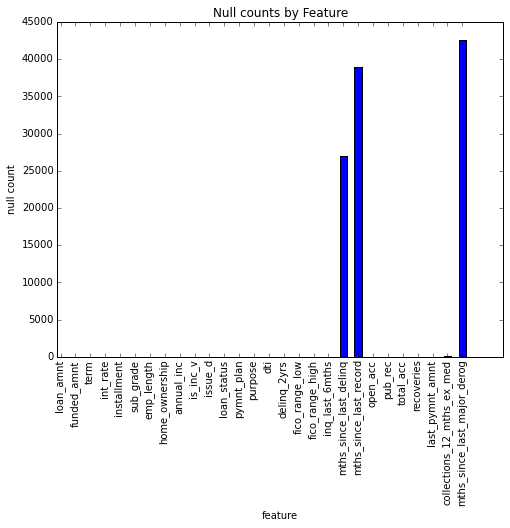

In [165]:
# Plot the isnulls()....

lcd_nulls=[]
features = lcd.columns
x_axis = np.arange(len(lcd.columns))

bar_width =0.5

# Figure out the count of nulls per feature
for r in lcd.columns:
        lcd_nulls.append(lcd[r].isnull().sum())
        
# Make a bar chart
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.bar(x_axis, lcd_nulls,width=bar_width)
plt.xticks(x_axis+bar_width/2,features,rotation=90)
plt.xlabel('feature')
plt.ylabel('null count')
plt.title('Null counts by Feature')
# plt.show()

Conclusion based on the above graph is that 3 features "mnths_since_last_delinq", "mnths_since_last_record",
mnths_since_last_major_derog contain NaN as a way of transmitting information - specifically
There was no activity for the feature described. 
All the other features have Nan occur sufficiently infrequently that we can assume that it is a data problem and 
Hence can use dropna() is needed.

In [131]:
print lcd.dtypes
# Some data will need to be cleaned. 

loan_amnt                        int64
funded_amnt                      int64
term                            object
int_rate                        object
installment                    float64
sub_grade                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
is_inc_v                        object
issue_d                         object
loan_status                     object
pymnt_plan                      object
purpose                         object
dti                            float64
delinq_2yrs                    float64
fico_range_low                   int64
fico_range_high                  int64
inq_last_6mths                 float64
mths_since_last_delinq         float64
mths_since_last_record         float64
open_acc                       float64
pub_rec                        float64
total_acc                      float64
recoveries                     float64
last_pymnt_amnt          

Axes(0.125,0.125;0.775x0.775)


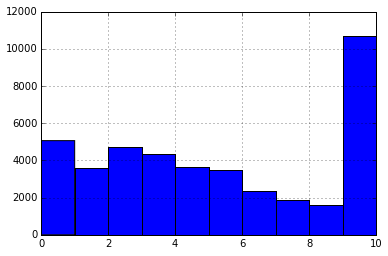

In [134]:
#lcd.emp_length.unique()
#array(['10+ years', , '1 year', '3 years', '8 years', '9 years',
#        '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a'], dtype=object)
lcd['emp_length_numeric'] = lcd['emp_length'].map({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, 
                                                  '4 years':4,'5 years':5,'6 years':6,'7 years':7,
                                                  '8 years':8,'9 years':9,'10+ years':10})

print lcd['emp_length_numeric'].hist()

In [154]:
# clean term by splitting on spaces and converting numbers into float
lcd['clean_term'] = [float(r.split(' ')[1]) for r in lcd.term]
lcd['clean_term'].describe()

count    42535.000000
mean        42.207218
std         10.509342
min         36.000000
25%         36.000000
50%         36.000000
75%         60.000000
max         60.000000
Name: clean_term, dtype: float64

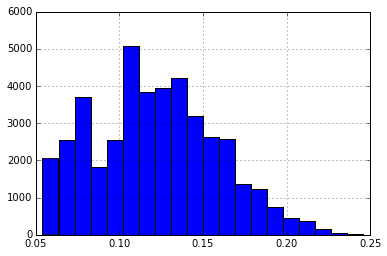

In [137]:
# Strip chars, convert int_rate series to float
lcd['clean_rates'] = [float(r.strip(' %'))/100 for r in lcd.int_rate]

lcd['clean_rates'].hist(bins=20)

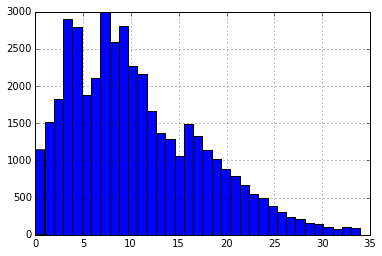

In [185]:
# print lcd['sub_grade'].unique()
#['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4' 'C2'
# 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5' 'G4' 'E2'
# 'G3' 'G2' 'G1' 'F5' 'G5']

lcd['sub_grade_int']=lcd['sub_grade'].map({'A1':0,'A2':1,'A3':2,'A4':3,'A5':4,
                                           'B1':5,'B2':6,'B3':7,'B4':8,'B5':9,
                                           'C1':10,'C2':11,'C3':12,'C4':13,'C5':14,
                                           'D1':15,'D2':16,'D3':17,'D4':18,'D5':19,
                                           'E1':20,'E2':21,'E3':22,'E4':23,'E5':24,
                                           'F1':25,'F2':26,'F3':27,'F4':28,'F5':29,
                                           'G1':30,'G2':31,'G3':32,'G4':33,'G5':34})

lcd['sub_grade_int'].hist(bins=35)
                                           

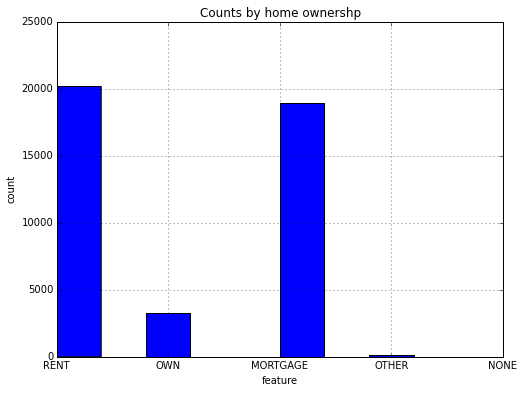

In [186]:
# print lcd['home_ownership'].unique()
# ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']

# Map ownership type to categorical variable
lcd['home_ownership_int'] = lcd['home_ownership'].map({'RENT':0, 'OWN':1, 'MORTGAGE':2, 'OTHER':3, 'NONE':4})

plt.figure(num=2, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ownership_type = ('RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE')
lcd['home_ownership_int'].hist()
plt.xticks(np.arange(5),('RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE'))
plt.xlabel('feature')
plt.ylabel('count')
plt.title('Counts by home ownershp')

In [116]:
# print lcd['is_inc_v'].unique()
# ['Verified' 'Source Verified' 'Not Verified']
lcd['is_inc_v_bool']= (lcd['is_inc_v']== 'Verified') | (lcd['is_inc_v'] =='Source Verified')

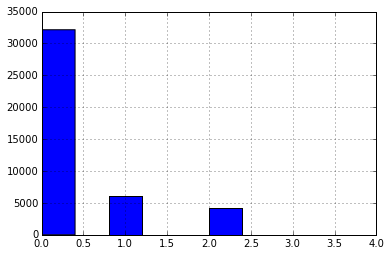

In [180]:
# print lcd['loan_status'].unique()
# ['Fully Paid' 'Charged Off' 'Current' 'Default' 'Late (31-120 days)'
#  'In Grace Period' 'Late (16-30 days)'
# 'Does not meet the credit policy.  Status:Current'
# 'Does not meet the credit policy.  Status:Charged Off'
# 'Does not meet the credit policy.  Status:Fully Paid'
# 'Does not meet the credit policy.  Status:Late (16-30 days)'
# 'Does not meet the credit policy.  Status:In Grace Period'
# 'Does not meet the credit policy.  Status:Late (31-120 days)']

# This will become our Response variable (y)

# Create a calculated feature which simplifies the accounting.   
# Fold anything <30 days delinquent into current
# Fold any other delinquency not defaulted into delinquent
# Fold 'Does not meet the Credit Policy' into similar category for other loans
# 0 = Fully paid
# 1 = Charged off
# 2 = Current
# 3 = Default
# 4 = Late

lcd['loan_status_int']=lcd['loan_status'].map({'Fully Paid':0,'Charged Off':1,'Current':2,'Default':3,
                            'Late (31-120days)':4,'In Grace Period':2,'Late (16-30 days)':2,
                            'Does not meet the credit policy.  Status:Current':2,
                            'Does not meet the credit policy.  Status:Charged Off':1,
                            'Does not meet the credit policy.  Status:Fully Paid':0,
                            'Does not meet the credit policy.  Status:Late (16-30 days)':2,
                            'Does not meet the credit policy.  Status:In Grace Period':0,
                            'Does not meet the credit policy.  Status:Late (31-120 days)':4})                     
                           
lcd['loan_status_int'].hist()

In [192]:
# print lcd['pymnt_plan'].unique()
# ['n' 'y']

# Set up calculated feature which is boolean
lcd['pymnt_plan_bool']= (lcd['pymnt_plan']=='y').astype(bool)
lcd['pymnt_plan_bool'].head()

0    False
1    False
2    False
3    False
4    False
Name: pymnt_plan_bool, dtype: bool

In [106]:
# print lcd['purpose'].unique() 
# ['credit_card' 'car' 'small_business' 'other' 'wedding'
#  'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
#  'moving' 'vacation' 'house' 'renewable_energy' 'educational']


Index([u'loan_amnt', u'funded_amnt', u'term', u'int_rate', u'installment', u'sub_grade', u'emp_length', u'home_ownership', u'annual_inc', u'is_inc_v', u'issue_d', u'loan_status', u'pymnt_plan', u'purpose', u'dti', u'delinq_2yrs', u'fico_range_low', u'fico_range_high', u'inq_last_6mths', u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc', u'pub_rec', u'total_acc', u'recoveries', u'last_pymnt_amnt', u'collections_12_mths_ex_med', u'mths_since_last_major_derog', u'home_ownership_int', u'loan_status_int', u'sub_grade_int', u'fico_interp'], dtype='object')

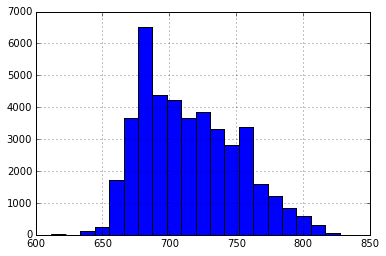

In [189]:
# Introduce calculated features
lcd['fico_interp']=(lcd['fico_range_low']+lcd['fico_range_high'])/2

lcd['fico_interp'].hist(bins=20)

lcd.columns

In [188]:
#  USE LEARNING CURVES TO FIND THE OPTIMAL SAMPLE SIZE TRAIN VS TEST DIm REduction Sample Size Reduction
#  SKLearn, feature selection - Feature
#  SkLean.Learning Curves - Sample Size
# Now lets just sample a small percentage of the data, say 5%
# convert lcd into array.  

lcd_sample1,lcd_sample2 = train_test_split(pd.DataFrame.as_matrix(lcd),test_size=0.05,random_state=123) 

#now convert the 'train' data back into a dataframe
lcd_small = pd.DataFrame(lcd_sample2,columns=lcd.columns)

lcd_small.columns

Index([u'loan_amnt', u'funded_amnt', u'term', u'int_rate', u'installment', u'sub_grade', u'emp_length', u'home_ownership', u'annual_inc', u'is_inc_v', u'issue_d', u'loan_status', u'pymnt_plan', u'purpose', u'dti', u'delinq_2yrs', u'fico_range_low', u'fico_range_high', u'inq_last_6mths', u'mths_since_last_delinq', u'mths_since_last_record', u'open_acc', u'pub_rec', u'total_acc', u'recoveries', u'last_pymnt_amnt', u'collections_12_mths_ex_med', u'mths_since_last_major_derog', u'home_ownership_int', u'loan_status_int', u'sub_grade_int'], dtype='object')

In [104]:
# Scatter plot of certain selected features.  
cols = ['loan_amnt', 'funded_amnt','int_rate']

pd.scatter_matrix(lcd_small[cols], figsize=(18, 18), alpha=0.05, diagonal='kde')

ValueError: num must be 0 <= num <= 0, not 1